<h1 style="font-family:Impact,Arial;font-size:30px;">37004 Interest Rates and Credit Risk Models - Spring 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 3</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37004 IRCRM" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />

Suppose that the dynamics of the default-free interest rate term structure are given by a one-factor Gaussian HJM model with volatility parameter $\sigma=0.025$ and mean reversion $a=0.08$. The current term structure is flat at 5\% continuously compounded for all maturities. Suppose further that the CDS spreads (paid annually, in arrears, in basis points) for a corporate entity <B>A</B> are deterministic and given by the following `pandas` dataframe:

In [31]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import norm

a = 0.08
nu = 0.025
r = 0.05
c = 0.4
m = 10

df = pd.DataFrame(
    [
        {"Maturity in years": 1, "Spread": 120},
        {"Maturity in years": 2, "Spread": 130},
        {"Maturity in years": 3, "Spread": 140},
        {"Maturity in years": 5, "Spread": 150},
        {"Maturity in years": 10, "Spread": 170},
    ]
)
df

,Maturity in years,Spread
0,1,120
1,2,130
2,3,140
3,5,150
4,10,170


Assume that default, recovery in default, and default-free interest rates are mutually independent. Expected recovery is 40\%. You may ignore accrued interest in the case of default. You may assume loglinear interpolation of risk-neutral probabilities of survival where necessary.

Entity <B>A</B> approaches a bank of negligible default risk, with the wish of <B>A</B> to enter into a 10-year interest swap, where <B>A</B> pays floating and receives fixed annually, with simple compounding.


<H2>Task 1:</H2>
Taking into account counterparty credit risk, what is the level of the fixed coupon on this swap, which results in a zero initial mark-to-market value of the swap? If some of the above assumptions are relaxed, in which case would the bank be exposed to "wrong-way risk" in this transaction? <I>(5 marks)</I>

**Finding the probabilities of default**

We need to find all the probabilities of default by setting *Premium leg = Default leg* and solving this equation for each k with :

$$V_{fixed} = s_k \sum^{k}_{i=1}P(0,T_i)B(0,T_i) $$

$$V_{float} = (1-c) \sum^{k}_{i=1}(P(0,T_{i-1}) - P(0,T_i))B(0,T_i) $$

Log linear interpolation of survival probabilities in case of missing spread between $T_1$ and $T_2$:

$$ \ln(P(0,T_i)) = \ln(P(0,T_1)) + \frac{T_i - T_1}{T_2 - T_1}\ln(\frac{P(0,T_2)}{P(0,T_1)}) $$

In [32]:
def interp(v1, v2, n):
    return np.array(
        [np.exp(np.log(v1) + ((i + 1) / (n + 1)) * np.log(v2 / v1)) for i in range(n)]
    )


def ZCB(nu, a, t, T, r):
    if t == T:
        return 1
    if t == 0:
        return np.exp(-r * T)
    else:
        int1 = np.exp(-2 * a * (T - t)) - np.exp(-2 * a * T)
        int2 = 1 - np.exp(-2 * a * t)
        int3 = np.exp(-a * (T - t)) - np.exp(-a * T)
        int4 = 1 - np.exp(-a * t)

        c1 = (nu**2) / (4 * a**3)
        c2 = (nu**2) / (a**3)

        temp = (c1 * (int1 - int2)) - (c2 * (int3 - int4))

        A = np.exp(-0.05 * (T - t) - temp)
        B = (1 / a) * (np.exp(-a * t) - np.exp(-a * T))
        return A * np.exp(-B * r)


def find_probabilities(rate, maturities, spreads, recovery):
    prob = []

    for i in range(len(maturities)):

        def f(x):
            result = []

            temp_prob = [1] + prob + list(x)
            temp_ZCBs = [ZCB(0, 0, 0, j, rate) for j in range(1, maturities[i] + 1)]

            p_leg = spreads[i] * np.dot(temp_prob[1:], temp_ZCBs)

            default_leg = (1 - recovery) * (1 - temp_prob[0]) * temp_ZCBs[0]
            default_leg = default_leg + (1 - recovery) * np.dot(
                np.array(temp_prob[:-1]) - np.array(temp_prob[1:]), temp_ZCBs
            )

            result.append(p_leg - default_leg)

            if len(x) > 1:
                temp_interp = interp(prob[-1], x[-1], len(x) - 1)
                for j in range(len(temp_interp)):
                    result.append(x[j] - temp_interp[j])

            return result

        temp_maturities = [0] + maturities
        res = list(
            fsolve(f, [j for j in range(temp_maturities[i + 1] - temp_maturities[i])])
        )
        prob += res
    return np.array(prob)


def find_swap_rate(maturity, rate):
    def to_solve(w):
        ZCBs = [ZCB(0, 0, 0, i, rate) for i in range(1, maturity + 1)]
        fixed_rate = [w] * maturity
        float_leg = 1 - ZCBs[-1]
        fixed_leg = np.dot(ZCBs, fixed_rate)
        return float_leg - fixed_leg

    return fsolve(to_solve, 0.03)[0]


def find_r(nu, a, w, t_i, m):
    def to_solve(r, nu, a, w, t_i):
        ZCBs = [ZCB(nu, a, t_i, i, r[0]) for i in range(t_i + 1, m + 1)]
        return 1 - ZCBs[-1] - (np.sum(ZCBs) * w)

    return fsolve(to_solve, [0], args=(nu, a, w, t_i))[0]


def B_S_var(T0, T1, a, nu):
    c1 = (nu**2) / (2 * (a**3))
    c2 = (-(nu**2)) / (a**3)

    int1 = np.exp(-2 * a * (T1 - T0)) - np.exp(-2 * a * T1)
    int2 = 1 - np.exp(-2 * a * T0)
    int3 = np.exp(-a * (T1 - T0)) - np.exp(-a * (T1 + T0))

    return (c1 * int1) + (c1 * int2) + (c2 * int3)


def h1(K, T0, T1, a, nu, r):

    X = np.log(ZCB(nu, a, 0, T1, r) / (ZCB(nu, a, 0, T0, r) * K))
    mean = 0.5 * B_S_var(T0, T1, a, nu)
    stdev = np.sqrt(B_S_var(T0, T1, a, nu))

    return (X + mean) / stdev


def h2(K, T0, T1, a, nu, r):

    X = np.log(ZCB(nu, a, 0, T1, r) / (ZCB(nu, a, 0, T0, r) * K))
    mean = 0.5 * B_S_var(T0, T1, a, nu)
    stdev = np.sqrt(B_S_var(T0, T1, a, nu))

    return (X - mean) / stdev


def B_S_price(K, T0, T1, a, nu, r, callput):

    h1_ = h1(K, T0, T1, a, nu, r)
    h2_ = h2(K, T0, T1, a, nu, r)
    return callput * (
        ZCB(nu, a, 0, T1, r) * norm.cdf(callput * h1_)
        - ZCB(nu, a, 0, T0, r) * K * norm.cdf(callput * h2_)
    )


def swaption_value(r_star, t_i, t_N, a, nu, w, r, callput):

    options = [
        B_S_price(ZCB(nu, a, t_i, i, r_star), t_i, i, a, nu, r, callput)
        for i in range(t_i + 1, t_N + 1)
    ]
    return options[-1] + (w * np.sum(options))


def npv(nu, a, rate, t, T, w):
    return -w * np.sum([ZCB(nu, a, t, i, rate) for i in range(t + 1, T + 1)])


def expected_loss(w, probabilities, c, m, r, callput):
    proba_default = np.concatenate(([1.0], probabilities[:-1])) - probabilities
    result = 0
    for i in range(1, m):
        r_star = find_r(nu, a, w, i, m)
        result += proba_default[i - 1] * swaption_value(
            r_star, i, m, a, nu, w, r, callput
        )
    return (1 - c) * result


def find_fair_rate(nu, a, r, m, c, maturities, spreads):

    w = find_swap_rate(m, r)
    probabilities = find_probabilities(r, maturities, spreads, c)

    def to_solve(s, nu, a, r, m, c, probabilities):
        return expected_loss(w + s[0], probabilities, c, m, r, -1) - npv(
            nu, a, r, 0, m, s[0]
        )

    s = fsolve(to_solve, [0], args=(nu, a, r, m, c, probabilities))[0]

    return w, s


w, s = find_fair_rate(
    nu, a, r, m, c, list(df["Maturity in years"]), np.array(df["Spread"]) / 1e4
)
print(
    f"The fair rate that the bank should pay is {round(w, 10)}{round(s, 10)} = {round(w + s, 10)}"
)

The fair rate that the bank should pay is 0.0512710964-0.0008143749 = 0.0504567214


The bank would be exposed to wrong way risk if the market interest rates and risk of default of entity A are positively correlated. Indeed, when the interest rates rise, the ZCB prices decrease thus increasing the exposure of the bank to entity A, which is not ideal when the probability of default increases too.

<H2>Task 2:</H2>
Suppose the bank has an existing swap with the same counterparty, where the bank pays floating and receives fixed annually, with simple compounding. This swap has exactly three years left to run, and the fixed leg was set at 4.75% (simple compounding).

1. In this situation, what is the answer to Task 1 if there is no netting agreement in place? If there is a netting agreement in place? <I>(5 marks)</I>
2. Suppose further that the market price interest rate risk relevant in this context is constant $\sigma_{\hat H}=0.15$. With and without netting, determine the potential future exposure (PFE) for the bank for a one-year time horizon, with 99\% confidence level, just before and just after entering into the 10-year swap with <B>A</B>. What is the impact of the market price of risk on the PFE?
<I>(5 marks)</I>

#### 1.

No netting:

In [33]:
def find_fair_rate(nu, a, r, m, c, maturities, spreads):

    w = find_swap_rate(m, r)
    probabilities = find_probabilities(r, maturities, spreads, c)

    def to_solve(s, nu, a, r, m, c, probabilities):
        return (
            expected_loss(w + s[0], probabilities, c, m, r, -1)
            + expected_loss(0.0475, probabilities, c, 3, r, 1)
            - npv(nu, a, r, 0, m, s[0])
        )

    s = fsolve(to_solve, [0], args=(nu, a, r, m, c, probabilities))[0]

    return w, s


w1, s1 = find_fair_rate(
    nu, a, r, m, c, list(df["Maturity in years"]), np.array(df["Spread"]) / 1e4
)
print(
    f"The fair rate that the bank should pay without netting is {round(w1, 10)}{round(s1, 10)} = {round(w1 + s1, 10)}"
)

The fair rate that the bank should pay without netting is 0.0512710964-0.0008531058 = 0.0504179906


With netting :

In [34]:
def find_r(nu, a, w, t_i, m1, m2):
    def to_solve(r, nu, a, w, t_i):
        ZCBs = [ZCB(nu, a, t_i, i, r[0]) for i in range(t_i + 1, m1 + 1)]
        result = 1 - ZCBs[-1] - (np.sum(ZCBs) * w)
        if t_i < m2:
            ZCBs = [ZCB(nu, a, t_i, i, r[0]) for i in range(t_i + 1, m2 + 1)]
            result = result + (np.sum(ZCBs) * 0.0475) - 1 + ZCBs[-1]
        return result

    return fsolve(to_solve, [0], args=(nu, a, w, t_i))[0]


def swaption_value(r_star, t_i, t_N1, t_N2, a, nu, w1, w2, r):

    options = [
        B_S_price(ZCB(nu, a, t_i, i, r_star), t_i, i, a, nu, r, -1)
        for i in range(t_i + 1, t_N1 + 1)
    ]
    result = options[-1] + (w1 * np.sum(options))
    if t_i < t_N2:
        options = [
            B_S_price(ZCB(nu, a, t_i, i, r_star), t_i, i, a, nu, r, -1)
            for i in range(t_i + 1, t_N2 + 1)
        ]
        result = result - options[-1] - (w2 * np.sum(options))
    return result


def expected_loss(w, probabilities, c, m1, m2, r):
    proba_default = np.concatenate(([1.0], probabilities[:-1])) - probabilities
    result = 0
    for i in range(1, m1):
        r_star = find_r(nu, a, w, i, m1, m2)
        result += proba_default[i - 1] * swaption_value(
            r_star, i, m1, m2, a, nu, w, 0.0475, r
        )
    return (1 - c) * result


def find_fair_rate(nu, a, r, m, c, maturities, spreads):

    w = find_swap_rate(m, r)
    probabilities = find_probabilities(r, maturities, spreads, c)

    def to_solve(s, nu, a, r, m, c, probabilities):
        return expected_loss(w + s[0], probabilities, c, m, 3, r) - npv(
            nu, a, r, 0, m, s[0]
        )

    s = fsolve(to_solve, [0], args=(nu, a, r, m, c, probabilities))[0]

    return w, s


w2, s2 = find_fair_rate(
    nu, a, r, m, c, list(df["Maturity in years"]), np.array(df["Spread"]) / 1e4
)
print(
    f"The fair rate that the bank should pay with netting is {round(w2, 10)}{round(s2, 10)} = {round(w2 + s2, 10)}"
)

The fair rate that the bank should pay with netting is 0.0512710964-0.0007593512 = 0.0505117452


#### 2.

In [35]:
def new_ZCB(a, nu, r, T0, Ti, sigma_H, confidence):

    int1 = (
        -(nu / (2 * a**3))
        * np.exp(-a * (2 * T0 + Ti))
        * (1 - np.exp(a * T0))
        * (np.exp(a * T0) - np.exp(a * Ti))
        * (-nu + np.exp(a * T0) * (nu + (2 * a * sigma_H)))
    )

    int2 = B_S_var(T0, Ti, a, nu)

    c1 = ZCB(nu, a, 0, Ti, r) / ZCB(nu, a, 0, T0, r)
    c2 = norm.ppf(1 - confidence)

    return c1 * np.exp((c2 * np.sqrt(int2)) + int1 - (0.5 * int2))


PFE_before = (
    (0.0475 * new_ZCB(a, nu, 0.05, 1, 2, 0.15, 0.01))
    + (1.0475 * new_ZCB(a, nu, 0.05, 1, 3, 0.15, 0.01))
    - 1
)
print("PFE before entering the 10y swap :", PFE_before)

# We know that the PV of each leg of the 10y swap is greater than the legs of the 3y one, that's why we only consider one side

ZCBs = [new_ZCB(a, nu, r, 1, i, 0.15, 0.99) for i in range(2, 11)]
cfs = [w1 + s1 for i in range(len(ZCBs))]
PFE_after_no_net = - np.dot(ZCBs, cfs) + 1 - ZCBs[-1]
print("PFE after entering the 10y swap (no netting) :", PFE_after_no_net)

cfs[0:2] = list(np.array(cfs[0:2]) - 0.0475)
PFE_after_net = -np.dot(ZCBs, cfs) - ZCBs[-1] + ZCBs[1]
print("PFE after entering the 10y swap (netting) :", PFE_after_net)

PFE before entering the 10y swap : 0.0899174751278704
PFE after entering the 10y swap (no netting) : 0.28499445970774706
PFE after entering the 10y swap (netting) : 0.17544871857529964


When we increase the $\sigma_H$, the price of the ZCB decreases thus decreasing the PFE for the floating part. This means that when the bank pays float before entering the new 10y swap, when the market risk increases, the PFE decreases. But conversly, once the bank enters the 10y swap, the bank receives more floating than it pays, thus inverting the sensitivity to market risk. In this case, with netting and without netting, the PFE increases when the market risk increases, as illustrated below in the no netting case.

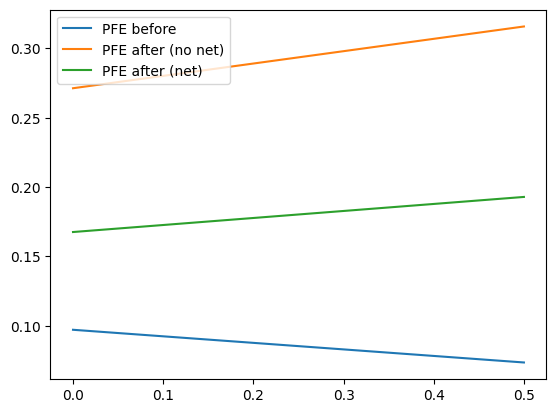

In [36]:
import matplotlib.pyplot as plt

def f1(sigma_H):
    return (
        (0.0475 * new_ZCB(a, nu, 0.05, 1, 2, sigma_H, 0.01))
        + (1.0475 * new_ZCB(a, nu, 0.05, 1, 3, sigma_H, 0.01))
        - 1
    )

def f2(sigma_H):
    ZCBs = [new_ZCB(a, nu, r, 1, i, sigma_H, 0.99) for i in range(2, 11)]
    cfs = [w1 + s1 for i in range(len(ZCBs))]
    return -np.dot(ZCBs, cfs) + 1 - ZCBs[-1]

def f3(sigma_H):
    ZCBs = [new_ZCB(a, nu, r, 1, i, sigma_H, 0.99) for i in range(2, 11)]
    cfs = [w1 + s1 for i in range(len(ZCBs))]
    cfs[0:2] = list(np.array(cfs[0:2]) - 0.0475)
    return -np.dot(ZCBs, cfs) - ZCBs[-1] + ZCBs[1]

x = np.linspace(0, 0.5, 2)
y1, y2, y3 = [], [], []
for i in x:
    y1.append(f1(i))
    y2.append(f2(i))
    y3.append(f3(i))

plt.plot(x, y1, label='PFE before')
plt.plot(x, y2, label='PFE after (no net)')
plt.plot(x, y3, label='PFE after (net)')
plt.legend()
plt.show()